## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Use Case 1

## Loading Required Prequisities
##### Note:  Need to run pip install play_scraper at the start of every session.

In [2]:
import json
import csv
import glob, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from functools import reduce
import calendar
from time import strptime
! pip install play_scraper
import play_scraper
import warnings
warnings.filterwarnings("ignore")


## Load the required JSON Files for analyses

In [3]:
fileName1 = ('/content/drive/My Drive/DataFiles/Google Play Store/Devices.json')
with open(fileName1, 'r', encoding='utf8', errors='ignore') as f1:
    Devicesfile = json.load(f1)
    print('Devices file loaded successfully.')
fileName2 = ('/content/drive/My Drive/DataFiles/Google Play Store/Installs.json')
with open(fileName2, 'r', encoding='utf8', errors='ignore') as f2:
    Installs = json.load(f2)
    print('Install file loaded successfully.')
fileName3 = ('/content/drive/My Drive/DataFiles/Google Play Store/Library.json')
with open(fileName3, 'r', encoding='utf8', errors='ignore') as f3:
    Library = json.load(f3)
    print('Library loaded successfully')
fileName5 = ('/content/drive/My Drive/DataFiles/Google Play Store/Play Settings.json')
with open(fileName5, 'r', encoding='utf8', errors='ignore') as f5:
    PlaySettings = json.load(f5)
    print('Play Settings loaded successfully.')
fileName6 = ('/content/drive/My Drive/DataFiles/Google Play Store/Purchase History.json')
with open(fileName6, 'r', encoding='utf8', errors='ignore') as f6:
    PurchaseHistory = json.load(f6)
    print('Purchase History loaded successfully')
fileName7 = ('/content/drive/My Drive/DataFiles/Google Play Store/Reviews.json')    
with open(fileName7, 'r', encoding='utf8', errors='ignore') as f7:
    Reviews = json.load(f7)
    print('Reviews file loaded successfully')

Devices file loaded successfully.
Install file loaded successfully.
Library loaded successfully
Order history loaded successfully.
Play Settings loaded successfully.
Purchase History loaded successfully
Reviews file loaded successfully


#### Set the user name and time format
Also check for existing data

In [4]:
Name = 'Dipro'
format ='%Y-%m-%d %H:%M:%S'
df_loaded_final = pd.DataFrame()
found = 0;
if glob.glob(f"/content/drive/My Drive/DataFiles/Google Play Store/Dataframe_GooglePlay_{Name}.csv"):
    found =1;
    print("Found")
    df_loaded_final = pd.read_csv(f"/content/drive/My Drive/DataFiles/Google Play Store/Dataframe_GooglePlay_{Name}.csv",  parse_dates=['AcquistionTime'])
    
    MaxAppID = df_loaded_final['App_ID'].max()
    MaxAcqTime=df_loaded_final['AcquistionTime'].max()

Found


## Devices used

In [5]:
deviceRegistrationTime = []
lastActive = [] 
Device_Manufacturer = []
Device_modelName = []
Device_carrierName = []
Device_IPCountry = []

for i in range(len(Devicesfile)):
    dictcol_recent = pd.DataFrame(Devicesfile[i].get('device').get('mostRecentData'))
    dictcol_recent = dictcol_recent.groupby(dictcol_recent.columns.difference(['nativePlatform']).tolist()).agg(lambda x: tuple(x)).applymap(list).reset_index()
    #dictcol_recent.columns = [str(col) + '_mostrecent' for col in dictcol_recent.columns]
    dictcol_recent = dictcol_recent.T
    dictcol_datalast = pd.DataFrame(Devicesfile[i].get('device').get('dataAtTimeOfUserPlayActivity'))
    dictcol_datalast = dictcol_datalast.groupby(dictcol_datalast.columns.difference(['nativePlatform']).tolist()).agg(lambda x: tuple(x)).applymap(list).reset_index()
    #dictcol_datalast.columns = [str(col) + '_datalastused' for col in dictcol_datalast.columns]
    dictcol_datalast = dictcol_datalast.T
    deviceRegistrationTime.append(pd.to_datetime(Devicesfile[i].get('device').get('deviceRegistrationTime'),format=format))
    lastActive.append(pd.to_datetime(Devicesfile[i].get('device').get('lastTimeDeviceActive'),format=format))
    
        
    Device_Manufacturer.append(Devicesfile[i].get('device').get('mostRecentData').get('manufacturer'))
    Device_modelName.append(Devicesfile[i].get('device').get('mostRecentData').get('modelName'))
    Device_carrierName.append(Devicesfile[i].get('device').get('mostRecentData').get('carrierName'))
    Device_IPCountry.append(Devicesfile[i].get('device').get('mostRecentData').get('deviceIpCountry'))
    
df_devices = pd.DataFrame(list(zip(Device_Manufacturer, Device_modelName, Device_carrierName, Device_IPCountry, deviceRegistrationTime, lastActive)), 
               columns =['Device_Manufacturer', 'ModelName', 'CarrierName', 'IPCountry', 'RegistrationTime', 'LastActive']) 
df_devices.head(2)

,Device_Manufacturer,ModelName,CarrierName,IPCountry,RegistrationTime,LastActive
0,Xiaomi,Redmi Note 4,KPN/Telfort,NL,2017-05-05 12:04:27.501000+00:00,2019-10-14 21:26:59.002959+00:00


## Device Installs Data

In [6]:
Title = []
Type = []
FirstInstall = []
LastUpdate = []
for i in range(len(Installs)):
    Title.append(Installs[i].get('install').get('doc').get('title'))
    Type.append(Installs[i].get('install').get('doc').get('documentType'))
    FirstInstall.append(pd.to_datetime(Installs[i].get('install').get('firstInstallationTime'),format=format))
    LastUpdate.append(pd.to_datetime(Installs[i].get('install').get('lastUpdateTime'),format=format))
    
df_installs = pd.DataFrame(list(zip(Title, Type, FirstInstall, LastUpdate)), 
               columns =['Title', 'Type', 'FirstInstallTime', 'LastUpdate']) 
df_installs.head(5)

,Title,Type,FirstInstallTime,LastUpdate
0,Facebook,Android Apps,2016-12-21 13:51:14.260000+00:00,2016-12-21 13:51:14.260000+00:00
1,Facebook,Android Apps,2016-07-31 08:18:34.569000+00:00,2016-12-16 03:06:49.710000+00:00
2,Facebook,Android Apps,2016-07-29 08:24:05.982000+00:00,2016-07-29 08:24:05.982000+00:00
3,"Google Play Books - Ebooks, Audiobooks, and Co...",Android Apps,2016-12-21 13:51:14.260000+00:00,2016-12-21 13:51:14.260000+00:00
4,"Google Play Books - Ebooks, Audiobooks, and Co...",Android Apps,2016-07-31 08:18:34.569000+00:00,2016-12-16 03:06:49.710000+00:00


## Library of apps used by the person

In [7]:
Type=[]
Title = []
AcquisitionTime=[]

for i in range(len(Library)):
    dummy_variable_1 = Library[i].get('libraryDoc')
    Type.append(dummy_variable_1.get('doc').get('documentType'))
    Title.append(dummy_variable_1.get('doc').get('title'))
    AcquisitionTime.append(pd.to_datetime(dummy_variable_1.get('acquisitionTime'),format=format))

df_Library = pd.DataFrame(list(zip(Type, Title, AcquisitionTime)), 
               columns =['Type', 'Title', 'AcquistionTime']) 
df_Library.head(5)

,Type,Title,AcquistionTime
0,Android Apps,Ladooo – Get Free Recharge App,2016-07-31 09:03:38.391000+00:00
1,Android Apps,Google+ for G Suite,2016-09-02 01:20:48.818000+00:00
2,Android Apps,MTK Engineering Mode,2016-09-07 15:37:09.814000+00:00
3,Android Apps,Google Play services,2016-10-04 09:26:35.220000+00:00
4,Android Apps,Xorware 2G/3G/4G Switcher,2016-10-24 07:54:53.434000+00:00


## Purchase History 

In [8]:
PurchaseHistory
itemTitle=[]
Method = []
invoicePrice = []
PurchaseTime = []
for i in range(len(PurchaseHistory)):
    dummy_purchase = PurchaseHistory[i].get('purchaseHistory')
    itemTitle.append(dummy_purchase.get('doc').get('title'))
    invoicePrice.append(dummy_purchase.get('invoicePrice'))
    PurchaseTime.append(pd.to_datetime(dummy_purchase.get('purchaseTime'),format=format))
    Method.append(dummy_purchase.get('paymentMethodTitle'))
df_Purchase = pd.DataFrame(list(zip(itemTitle, Method, invoicePrice, PurchaseTime)), 
               columns =['Title', 'Method','invoicePrice', 'PurchaseTime']) 

df_Purchase.head(3)   

,Title,Method,invoicePrice,PurchaseTime
0,Space Shooter: Alien vs Galaxy Attack (Premium),,€0.00,2019-08-07 01:49:24.553000+00:00
1,Unknown Item,,₹0.00,2018-11-24 20:24:34.332000+00:00
2,Where's My Water?,Google Play balance: ₹ 10.99,₹10.00,2017-10-11 11:17:23.867000+00:00


In [9]:
print('Total Amount Spent:')
dummy = df_Purchase.invoicePrice.str.split('(\d+.\d+)',expand = True)
dummy.columns = ['Currency','Amount', 'None']
dummy.drop('None',axis =1, inplace=True)
dummy.Amount = dummy.Amount.astype(float)
dummy = dummy.groupby(['Currency']).sum()#.transform('sum')
print(dummy)

Total Amount Spent:
          Amount
Currency        
€            0.0
₹           10.0


In [10]:
Type=[]
Title = []
AcquisitionTime=[]

for i in range(len(Library)):
    dummy_variable_1 = Library[i].get('libraryDoc')
    Type.append(dummy_variable_1.get('doc').get('documentType'))
    Title.append(dummy_variable_1.get('doc').get('title'))
    AcquisitionTime.append(pd.to_datetime(dummy_variable_1.get('acquisitionTime'),format=format))

df_Library = pd.DataFrame(list(zip(Type, Title, AcquisitionTime)), 
               columns =['Type', 'Title', 'AcquistionTime']) 
df_Library.head()

,Type,Title,AcquistionTime
0,Android Apps,Ladooo – Get Free Recharge App,2016-07-31 09:03:38.391000+00:00
1,Android Apps,Google+ for G Suite,2016-09-02 01:20:48.818000+00:00
2,Android Apps,MTK Engineering Mode,2016-09-07 15:37:09.814000+00:00
3,Android Apps,Google Play services,2016-10-04 09:26:35.220000+00:00
4,Android Apps,Xorware 2G/3G/4G Switcher,2016-10-24 07:54:53.434000+00:00


## PlaySettings (contains basic information about the user settings -like preregistered apps)

In [11]:
PlaySettings

[{'userSetting': {'preregistrationListItem': {'doc': {'documentType': 'Android Apps',
     'title': 'Diablo Immortal'}}}},
 {'userSetting': {'receivePlayMarketingEmail': False,
   'userCountryCode': 'NL'}}]

## Reviewed by the user

In [12]:
itemTitle = []
StarRating =[]
ReviewedTime=[]

for i in range (len(Reviews)):
    dummy_review = Reviews[i].get('review')
    itemTitle.append(dummy_review.get('document').get('title'))
    ReviewedTime.append(pd.to_datetime(dummy_review.get('creationTime'),format=format))
    StarRating.append(dummy_review.get('starRating'))

df_Reviews = pd.DataFrame(list(zip( itemTitle,StarRating, ReviewedTime)), 
               columns =['Title', 'StarRating', 'ReviewedTime'])  
df_Reviews.head(3)

,Title,StarRating,ReviewedTime
0,War Machines: Free Multiplayer Tank Shooting G...,5,2019-08-19 09:40:15.809000+00:00
1,Kick the Buddy: Forever,5,2019-08-07 13:11:17.449000+00:00
2,"Shop Titans: Epic Idle Crafter, Build & Trade RPG",5,2019-07-03 22:10:41.272000+00:00


In [13]:
df_Reviews.StarRating.value_counts()

5    6
4    2
Name: StarRating, dtype: int64

### Dataframe for final data analyses

In [14]:
df_s = [df_Library, df_Purchase, df_Reviews]
df_final = reduce(lambda  left,right: pd.merge(left,right,on=['Title'],
                                            how='outer'), df_s).fillna('NaN')
for i in range(len(df_final)):
    if df_final.AcquistionTime[i]=='NaN':
        df_final.AcquistionTime[i] = df_final.ReviewedTime[i]

df_final = df_final.dropna(subset=['AcquistionTime'])
#df_final.AcquistionTime
if found == 1:
        df_final=df_final[df_final.AcquistionTime>MaxAcqTime]
        Title = df_final.Title.tolist()
        df_final = pd.concat([df_loaded_final,df_final],ignore_index=True)
df_final.head(2)

,AcquistionTime,App_ID,Category,Content_Rating,Developer,Free,Interactive_Elements,Method,Price,PurchaseTime,ReviewedTime,Size,StarRating,Title,Type,Unnamed: 0,invoicePrice
0,2019-10-14 15:37:32.254000+00:00,com.allenmm.archery,GAME_SPORTS,Everyone,7788`s,True,NaN,NaN,0,NaN,NaN,87M,NaN,Shooting Archery,Android Apps,0.0,NaN
1,2019-10-14 15:36:18.055000+00:00,com.SPSoftwareProductions.TheRealJuggle,GAME_SPORTS,Everyone,Lion Studios,True,NaN,NaN,0,NaN,NaN,58M,NaN,The Real Juggle - Pro Freestyle Soccer,Android Apps,1.0,NaN


In [0]:
App_Title = []
Content_Rating = []
App_ID = []
Size =[]
Price = []
Free = []
Developer =[]
Category = []
Interactive_Elements = []
Acquisition_Time = []
for i in range(len(Title)):
    try:
        string_title = Title[i]
        a = play_scraper.search(string_title, page=0, detailed=True)
        print("No.:",i,"Title:", string_title)
        if len(a) == 0:
            print("no suitable items found for Title:", string_title)
            App_Title.append('None')
            Content_Rating.append('None')
            App_ID.append('None')
            Size.append('None')
            Price.append('None')
            Free.append('None')
            Developer.append('None')
            Category.append('None')
            Interactive_Elements.append('None')
            Acquisition_Time.append(pd.to_datetime(AcquisitionTime[i]))
        else:
            App_Title.append(a[0].get('title'))
            Content_Rating.append(a[0].get('content_rating'))
            App_ID.append(a[0].get('app_id'))
            Size.append(a[0].get('size'))
            Price.append(a[0].get('price'))
            Free.append(a[0].get('free'))
            Developer.append(a[0].get('developer'))
            Category.append(a[0].get('category'))
            Interactive_Elements.append(a[0].get('interactive_elements'))
            Acquisition_Time.append(pd.to_datetime(AcquisitionTime[i]))
            if a[0].get('title') == a[1].get('title'):
                print ("Alternative exists:")
                App_Title.append(a[1].get('title'))
                Content_Rating.append(a[1].get('content_rating'))
                App_ID.append(a[1].get('app_id'))
                Size.append(a[1].get('size'))
                Price.append(a[1].get('price'))
                Free.append(a[1].get('free'))
                Developer.append(a[1].get('developer'))
                Category.append(a[1].get('category'))
                Interactive_Elements.append(a[1].get('interactive_elements'))
                Acquisition_Time.append(pd.to_datetime(AcquisitionTime[i]))
            elif a[0].get('title') == a[2].get('title'):
                print ("Alternative exists:")
                App_Title.append(a[2].get('title'))
                Content_Rating.append(a[2].get('content_rating'))
                App_ID.append(a[2].get('app_id'))
                Size.append(a[2].get('size'))
                Price.append(a[2].get('price'))
                Free.append(a[2].get('free'))
                Developer.append(a[2].get('developer'))
                Category.append(a[2].get('category'))
                Interactive_Elements.append(a[2].get('interactive_elements'))
                Acquisition_Time.append(pd.to_datetime(AcquisitionTime[i]))

        print("Done")
    except:
        pass
    

In [16]:
df = pd.DataFrame(list(zip(App_Title, Content_Rating, App_ID, Size, Price, Free, Developer, Category, Interactive_Elements)), 
               columns =['Title', 'Content_Rating', 'App_ID', 'Size', 'Price', 'Free', 'Developer', 'Category', 'Interactive_Elements']) 
if len(df>0):
    df = df.drop(df[df.Category == 'None'].index)
    df['Category'] = df['Category'].apply(', '.join)
    df['Content_Rating'] = df['Content_Rating'].apply(', '.join)
    pd.concat([pd.Series(row['Category'].split(','))              
                    for _, row in df.iterrows()]).reset_index()

    df_final=df_final.merge(df, on='Title').reset_index()
df_final=df_final[df_final.columns.drop(list(df_final.filter(regex='Unnamed')))]
df_final=df_final[df_final.columns.drop(list(df_final.filter(regex='level')))]
df_final = df_final.sort_values(by=['AcquistionTime'],ascending=False).reset_index().drop('index',axis=1)

df_final.to_csv(f"Dataframe_GooglePlay_{Name}.csv")

df_final.head(2)

,AcquistionTime,App_ID,Category,Content_Rating,Developer,Free,Interactive_Elements,Method,Price,PurchaseTime,ReviewedTime,Size,StarRating,Title,Type,invoicePrice
0,2019-10-14 15:37:32.254000+00:00,com.allenmm.archery,GAME_SPORTS,Everyone,7788`s,True,NaN,NaN,0,NaN,NaN,87M,NaN,Shooting Archery,Android Apps,NaN
1,2019-10-14 15:36:18.055000+00:00,com.SPSoftwareProductions.TheRealJuggle,GAME_SPORTS,Everyone,Lion Studios,True,NaN,NaN,0,NaN,NaN,58M,NaN,The Real Juggle - Pro Freestyle Soccer,Android Apps,NaN


## Category Analysis :Apps and  Games Sub Category

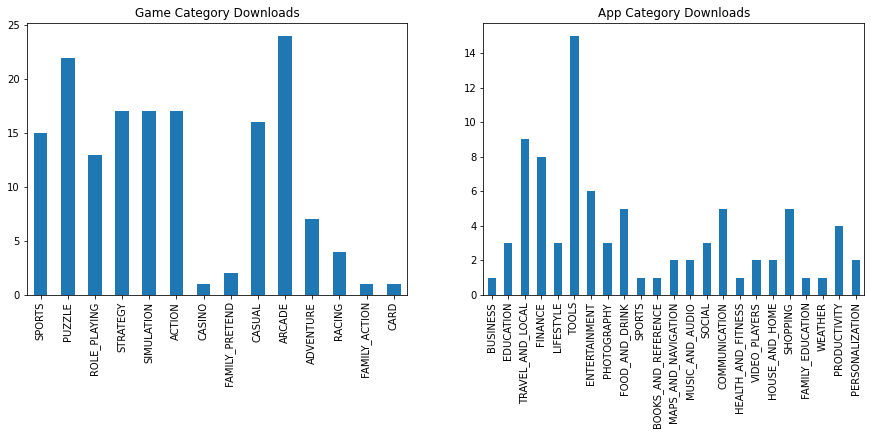

In [17]:
df_Game= df_final[df_final['Category'].str.contains("GAME")]
df_Game[['Game','Type']]=df_Game.pop('Category').str.split('_', n=1, expand=True)
df_Game.Type = df_Game.Type.str.split(',')
df_Game = df_Game.explode('Type')


df_App= df_final[df_final['Category'].str.contains("GAME")==False]
df_App.Category = df_App.Category.str.split(',')
df_App = df_App.explode('Category')


fig, (axs1,axs2) =plt.subplots(1,2, figsize =(15,5))
game_cat_list = list(df_Game.Type.unique())
df_Game.Type.value_counts().loc[game_cat_list].plot(kind='bar', title=f'Game Category Downloads', ax=axs1)
app_cat_list = list(df_App.Category.unique())
df_App.Category.value_counts().loc[app_cat_list].plot(kind='bar', title=f'App Category Downloads',ax=axs2)
plt.show()

In [20]:
df_Game.head()

,AcquistionTime,App_ID,Content_Rating,Developer,Free,Interactive_Elements,Method,Price,PurchaseTime,ReviewedTime,Size,StarRating,Title,Type,invoicePrice,Game
0,2019-10-14 15:37:32.254000+00:00,com.allenmm.archery,Everyone,7788`s,True,NaN,NaN,0,NaN,NaN,87M,NaN,Shooting Archery,SPORTS,NaN,GAME
1,2019-10-14 15:36:18.055000+00:00,com.SPSoftwareProductions.TheRealJuggle,Everyone,Lion Studios,True,NaN,NaN,0,NaN,NaN,58M,NaN,The Real Juggle - Pro Freestyle Soccer,SPORTS,NaN,GAME
2,2019-10-14 10:42:53.319000+00:00,com.rope.cut,Everyone,SayGames,True,NaN,NaN,0,NaN,NaN,26M,NaN,Rope Slash,PUZZLE,NaN,GAME
3,2019-10-13 00:27:35.132000+00:00,com.wb.goog.dc.legends,"Teen, Violence",Warner Bros. International Enterprises,True,['Digital Purchases'],NaN,0,NaN,NaN,70M,NaN,DC Legends: Battle for Justice,ROLE_PLAYING,NaN,GAME
4,2019-10-12 22:26:06.213000+00:00,com.pixelfederation.ts2,Everyone,Pixel Federation Games,True,['Digital Purchases'],NaN,0,NaN,NaN,70M,NaN,Train Station 2: Real Train Tycoon Simulator,STRATEGY,NaN,GAME


In [21]:
df_Game[df_Game.AcquistionTime.dt.year==pd.datetime.now().year].Type.value_counts().loc[game_cat_list].plot(kind='bar', title=f'{pd.datetime.now().year}', ax=axs[1,0])

KeyError: ignored

In [0]:
#fig =plt.figure()
#fig, axs =plt.subplots(2,2, figsize =(15,9))
#fig.suptitle('Game Category Downloads            App Category Downloads', fontsize=12, fontweight='bold')
#fig.subplots_adjust(top=30.75)
#df_Game[df_Game.AcquistionTime.dt.year==pd.datetime.now().year].Type.value_counts().loc[game_cat_list].plot(kind='bar', title=f'{pd.datetime.now().year}', ax=axs[1,0])
#df_Game[df_Game.AcquistionTime.dt.year==(pd.datetime.now().year - 1)].Type.value_counts().loc[game_cat_list].plot(kind='bar', title=f'{pd.datetime.now().year - 1}', ax=axs[0,0])


#df_App[df_App.AcquistionTime.dt.year==pd.datetime.now().year].Category.value_counts().loc[app_cat_list].plot(kind='bar', title=f'{pd.datetime.now().year}', ax=axs[1,1])
#df_App[df_App.AcquistionTime.dt.year==(pd.datetime.now().year-1)].Category.value_counts().loc[app_cat_list].plot(kind='bar', title=f'{pd.datetime.now().year-1}', ax=axs[0,1])

#plt.show()
#plt.tight_layout()

In [23]:
print('Favourite App Category: ', df_App.Category.mode()[0])
print('Favourite Game Category: ', df_Game.Type.mode()[0])

Favourite App Category:  TOOLS
Favourite Game Category:  ARCADE


## Google Play Activity with Time 

*   ####  By Year



<Figure size 432x288 with 0 Axes>

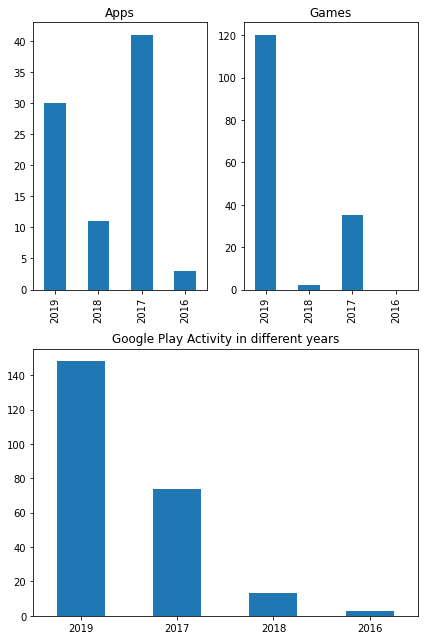

In [24]:
fig =plt.figure()
fig = plt.subplots(figsize =(6,9))

ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0), colspan=2)
#plt.subplots_adjust(bottom=-0.1, right=0.8, top=0.1)
years = list(df_final['AcquistionTime'].dt.year.unique())
df_final['AcquistionTime'].dt.year.value_counts().plot(kind='bar', title ='Google Play Activity in different years',ax=ax3,xticks=[])
df_App['AcquistionTime'].dt.year.value_counts().loc[years].plot(kind='bar', title ='Apps',ax=ax1)
df_Game['AcquistionTime'].dt.year.value_counts().loc[years].plot(kind='bar', title ='Games',ax=ax2)
plt.tight_layout()

*   #### By Month

<Figure size 432x288 with 0 Axes>

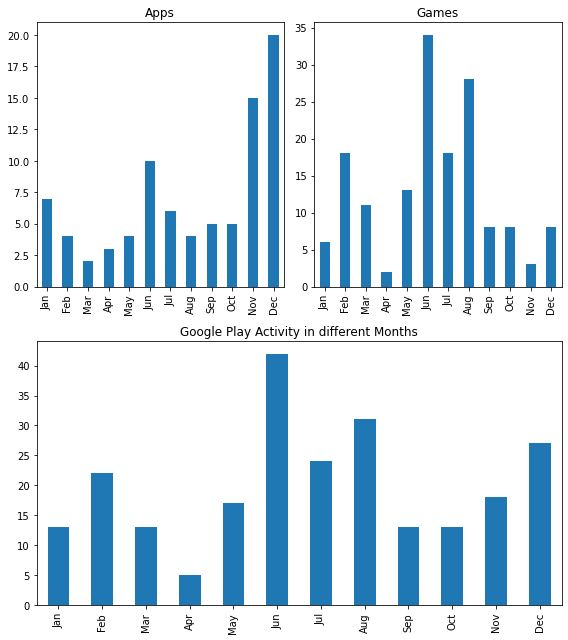

In [25]:
fig =plt.figure()
fig = plt.subplots(sharey=True, sharex =True, figsize =(8,9))
monthsL = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Month_Total = df_final['AcquistionTime'].dt.month.apply(lambda x: calendar.month_abbr[x])
Month_Game = df_Game['AcquistionTime'].dt.month.apply(lambda x: calendar.month_abbr[x])
Month_App = df_App['AcquistionTime'].dt.month.apply(lambda x: calendar.month_abbr[x])
ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0), colspan=2)

Month_Total.value_counts().loc[monthsL].plot(kind='bar', title ='Google Play Activity in different Months', ax = ax3)
Month_App.value_counts().loc[monthsL].plot(kind='bar', title ='Apps', ax = ax1)
Month_Game.value_counts().loc[monthsL].plot(kind='bar', title ='Games', ax = ax2)
plt.tight_layout()


* #### By Day

<Figure size 432x288 with 0 Axes>

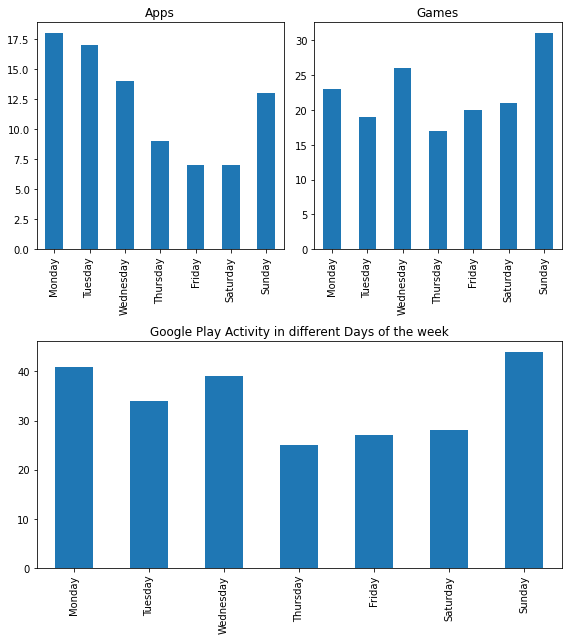

In [26]:
fig =plt.figure()
fig = plt.subplots(sharey=True, sharex =True, figsize =(8,9))
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
Day_Total = df_final['AcquistionTime'].dt.day_name()
Day_Game = df_Game['AcquistionTime'].dt.day_name()
Day_App = df_App['AcquistionTime'].dt.day_name()
ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0), colspan=2)

Day_Total.value_counts().loc[days].plot(kind='bar', title ='Google Play Activity in different Days of the week', ax = ax3)
Day_App.value_counts().loc[days].plot(kind='bar', title ='Apps', ax = ax1)
Day_Game.value_counts().loc[days].plot(kind='bar', title ='Games', ax = ax2)
plt.tight_layout()

* #### By Quarter of Day

<Figure size 432x288 with 0 Axes>

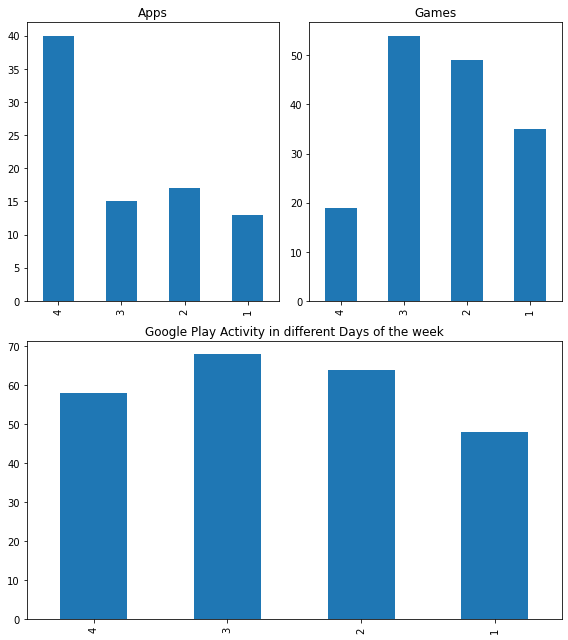

In [27]:
fig =plt.figure()
fig = plt.subplots(sharey=True, sharex =True, figsize =(8,9))
#days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

Quarter_Total = df_final['AcquistionTime'].dt.quarter

Quarter = Quarter_Total.unique()
Quarter_Game = df_Game['AcquistionTime'].dt.quarter
Quarter_App = df_App['AcquistionTime'].dt.quarter
ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0), colspan=2)

Quarter_Total.value_counts().loc[Quarter].plot(kind='bar', title ='Google Play Activity in different Days of the week', ax = ax3)
Quarter_App.value_counts().loc[Quarter].plot(kind='bar', title ='Apps', ax = ax1)
Quarter_Game.value_counts().loc[Quarter].plot(kind='bar', title ='Games', ax = ax2)
plt.tight_layout()

## Amount of Data Downloaded

In [0]:
df_Total_Size = pd.DataFrame()
df_Total_Size= df_final[['Size','Category','AcquistionTime']]
df_Total_Size = df_Total_Size[~df_Total_Size.Size.str.contains("Varies")]
def mult_func(value, cond):
    multiplier = {'G':1024*1024,'M': 1024, 'k': 1}
    return value*multiplier[cond]

df_Total_Size['Byte_Value'] = df_Total_Size['Size'].str.strip().str[-1]
df_Total_Size['Size'] = df_Total_Size['Size'].str.strip().str[:-1].astype(float)
df_Total_Size['Size_Std(kB)'] = df_Total_Size.apply(lambda x: mult_func(x['Size'],x['Byte_Value']),axis=1)

df_Game = df_Game[~df_Game.Size.str.contains("Varies")]
df_Game['Byte_Value'] = df_Game['Size'].str.strip().str[-1]
df_Game['Size'] = df_Game['Size'].str.strip().str[:-1].astype(float)
df_Game['Size_Std(kB)'] = df_Game.apply(lambda x: mult_func(x['Size'],x['Byte_Value']),axis=1)

df_App = df_App[~df_App.Size.str.contains("Varies")]
df_App['Byte_Value'] = df_App['Size'].str.strip().str[-1]
df_App['Size'] = df_App['Size'].str.strip().str[:-1].astype(float)
df_App['Size_Std(kB)'] = df_App.apply(lambda x: mult_func(x['Size'],x['Byte_Value']),axis=1)


In [0]:
Size_Total = df_Total_Size['Size_Std(kB)']
Size_Game = df_Game['Size_Std(kB)']
Size_App = df_Game['Size_Std(kB)']

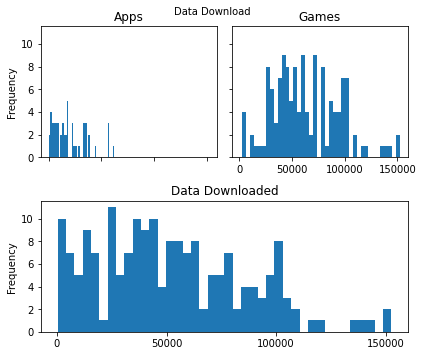

In [30]:
n_bin = 40
fig = plt.figure(figsize = (6,5))
gs = gridspec.GridSpec(2,2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1, sharex = ax1)
ax3 = fig.add_subplot(gs[1,0:], sharey=ax2, sharex = ax2)

plt.setp(ax1.get_xticklabels(), visible=True)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=True)
df_App['Size_Std(kB)'].plot(kind='hist', bins =n_bin, title ='Apps', ax = ax1)
df_Game['Size_Std(kB)'].plot(kind='hist', bins =n_bin, title ='Games', ax = ax2)
df_Total_Size['Size_Std(kB)'].plot(kind='hist', bins =n_bin, title ='Data Downloaded', ax = ax3)
#plt.setp(ax1, title='Test')
fig.suptitle('Data Download', size=10)
plt.tight_layout()


plt.show()

### Forecasting Data Usage

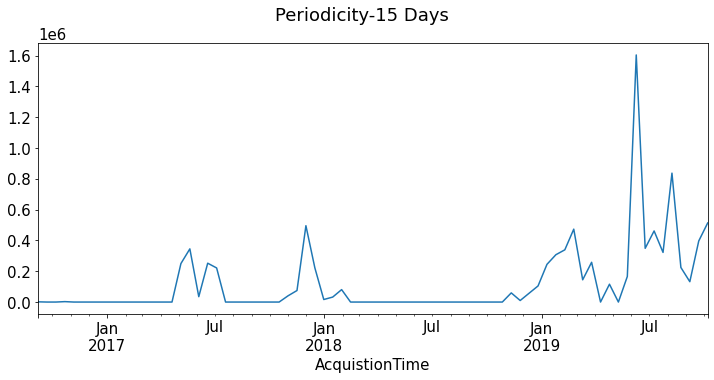

In [31]:
fig = plt.figure(figsize = (12,5))
df_Total_Size.drop_duplicates(subset=['AcquistionTime'], inplace=True)
df_TdummyD= df_Total_Size.set_index('AcquistionTime').resample('15D').agg('sum')
v_dumm = df_TdummyD['Size_Std(kB)']
plt.rcParams.update({'font.size': 15})
fig.suptitle('Periodicity-15 Days')
v_dumm.plot(figsize=(12, 5))

<Figure size 864x648 with 0 Axes>

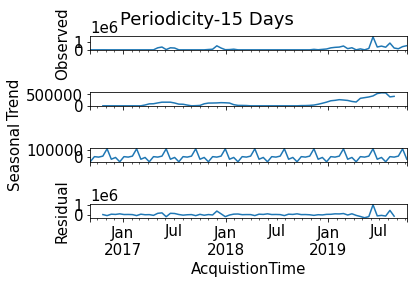

In [32]:
from pylab import rcParams
import statsmodels.api as sm
fig = plt.figure(figsize = (12,9))
#rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(v_dumm, model='additive')
fig = decomposition.plot()
plt.rcParams.update({'font.size': 15})
fig.suptitle('Periodicity-15 Days')
plt.show()

In [33]:
#A=B=0
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[1], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
AIC_VAL= 1000.0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(v_dumm,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if results.aic<= AIC_VAL:
                A = param
                B = param_seasonal
                AIC_VAL = results.aic
                #print('ii', param, param_seasonal)
            else: 
                None
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print(A,B,AIC_VAL)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2090.4215658918456
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1763.2613186837266
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:4744.9335251095035
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1459.9363846597137
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1437.5549740456943
ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:803.4107693196084
ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:802.3662995403943
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2090.4215658918456
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1763.2613186837266
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:4744.9335251095035
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1459.9363846597137
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1437.5549740456943
ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:803.4107693196084
ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:802.3662995403943
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2090.4215658918456
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1763.2613186837266
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:4744.9335251095035
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1459.9363846597

In [34]:
mod = sm.tsa.statespace.SARIMAX(v_dumm,
                                order=A,
                                seasonal_order=B,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0865      0.865      0.100      0.920      -1.608       1.781
ar.L2          0.0236      0.788      0.030      0.976      -1.521       1.568
ma.L1         -1.8725      0.702     -2.667      0.008      -3.248      -0.497
ma.L2          0.8731      0.706      1.237      0.216      -0.511       2.257
ar.S.L12      -0.7788      1.990     -0.391      0.696      -4.680       3.122
ar.S.L24      -0.4422      2.395     -0.185      0.853      -5.136       4.251
sigma2      2.202e+11   1.67e-11   1.32e+22      0.000     2.2e+11     2.2e+11


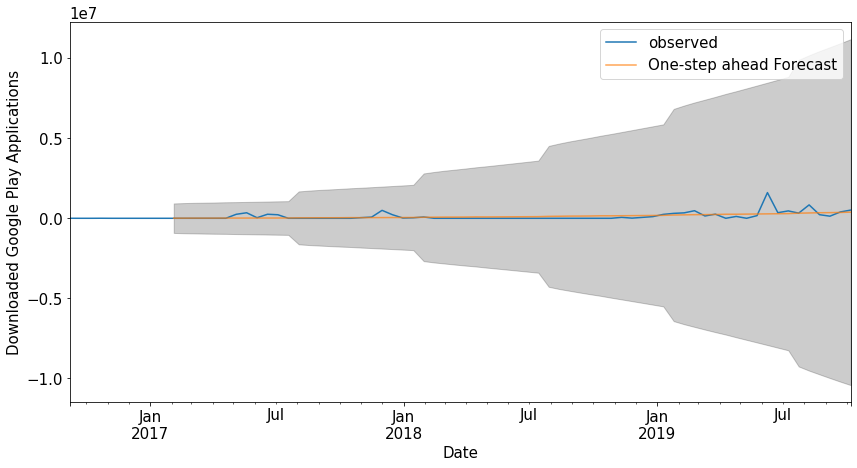

In [35]:
pred = results.get_prediction(start=df_TdummyD[10:].index.min(), dynamic=True)
pred_ci = pred.conf_int()
fig, ax =plt.subplots()
ax = v_dumm.plot(label='observed')
pred.predicted_mean.plot( label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Downloaded Google Play Applications')

plt.legend()
plt.show()

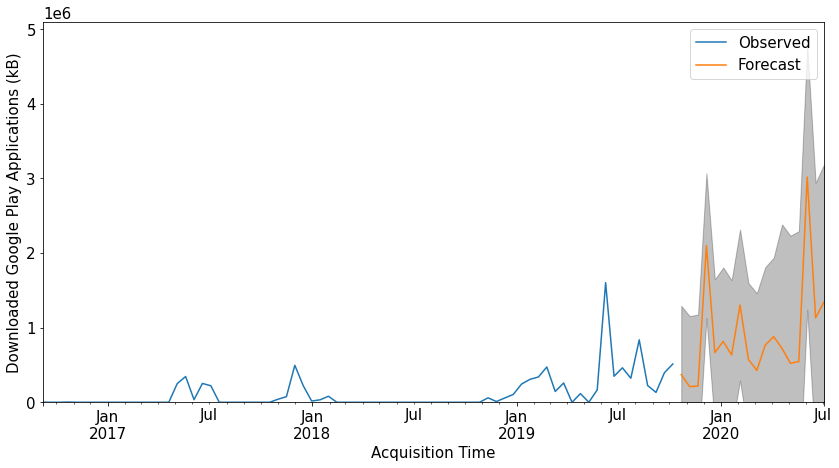

In [36]:
pred_uc = results.get_forecast(steps=18)
pred_ci = pred_uc.conf_int()
ax = v_dumm.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Acquisition Time')
ax.set_ylabel('Downloaded Google Play Applications (kB)')
plt.rcParams.update({'font.size': 15})
fig.suptitle('Forecast')
plt.ylim(-2000, ax.get_ylim()[1]) 
plt.legend()
plt.show()